Aufgaben die zu erledigen sind:
- Product Shelf bereinigen --> schlecht gekaufte Produkte
- Produkte empfehlen die noch nicht eingekauft wurden

3 mögliche Systeme:
- Simple Recommender --> Top Products
    - Decide on the metric or score to rate products on
    - Calcualte the score for every product
    - Sort the products based on the score and output the top results
    
- Content Based Recommender --> Uses item meta data
- Collaborative Recommender --> Products from other user that looks pretty similar


Problems:
Contrarian to rating data, purchase data has no upper band of the evaluated score
There is no explicit rating data, so it has to be generated from implicit information available

Ressources:
- https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
- https://www.datacamp.com/community/tutorials/recommender-systems-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=229765585186&utm_targetid=aud-299261629574:dsa-473406569915&utm_loc_interest_ms=&utm_loc_physical_ms=20143&gclid=Cj0KCQiA-bjyBRCcARIsAFboWg2VIh0dOVFJAckISmcG52iT4y1gr732tQkw-i9-Pj2VubR5WXq4IWcaArhsEALw_wcB


Performance:
This might be an issue.
A possible solution is: https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # used for histogram


data = pd.read_csv ("Recommender4Retail.csv", index_col=[0]) # low_memory option is depricated
data.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
3,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
5,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


Description of the attributes (According to https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

- order_id: order identifier
- user_id: user identifier
- eval_set: which evaluation set this order belongs in (we only have Prior and Train) - no test?
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior_order: days since the last order, capped at 30 (with NaNs for order_number = 1)
- product_id: product identifier
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
- product_name: name of the product
- aisle_id: aisle identifier
- department_id: department identifier
- department: the name of the department
- ailse: the name of the aisle



In [8]:
# Exploring the Data
'''
- What is eval_set, order_dow, reordered and can what can they be used for?
- Can the amount a product has been bought, seen as a implicit ratings? There might be some problems to it depending on the product...
- 
'''
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 1 to 33819106
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  department              object 
 14  aisle                   object 
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00
std,9.874008e+05,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.710660e+06,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565587e+06,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [10]:
#Unique Values for specified colums
cols = ('eval_set','order_dow','reordered')
for var in cols:
    res = data[var].unique()
    print('{2}: UniqueValues {0}, No. of unique values {1} '.format(res,len(res),var))


#Count occurence of each value
#print(data.eval_set.value_counts())

eval_set: UniqueValues ['prior' 'train'], No. of unique values 2 
order_dow: UniqueValues [2 3 4 1 5 0 6], No. of unique values 7 
reordered: UniqueValues [0 1], No. of unique values 2 


user_id
201268    3725
129928    3689
164055    3089
176478    2952
186704    2936
137629    2931
182401    2929
33731     2912
108187    2760
4694      2735
Name: product_id, dtype: int64


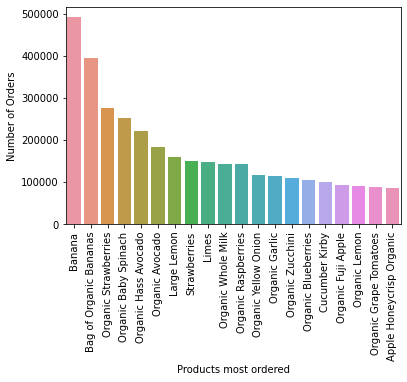

In [3]:
# number of departments
n_of_departments = data.department.nunique()

# amount of products bought by user
# show the top 10 user with most products bought
n_by_user = data.groupby('user_id')['product_id'].count()
print(n_by_user.nlargest(10))

# number of times a product is bought
# show the products most bought
n_of_products_bought = data.product_name.value_counts()
n_of_products_bought_20 = n_of_products_bought.nlargest(20)

plt.figure()
sns.barplot(x=n_of_products_bought_20.index, y=n_of_products_bought_20.values)
plt.xlabel('Products most ordered')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.savefig('prod_most_bought.png', bbox_inches='tight')
plt.show()

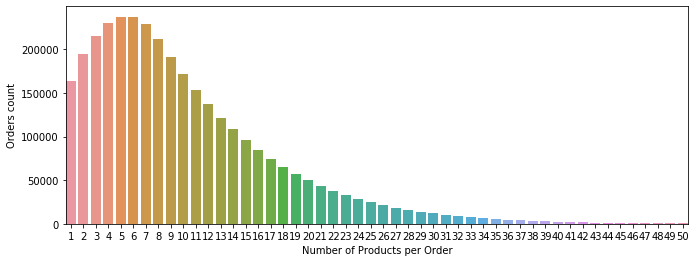

In [2]:
# Number of products bought per order
n_prod_order = data.groupby('order_id')['product_id'].count().value_counts().sort_index() # first row = number of products per order, second row = how many orders
# This does not consider if a product is bought multiple times in one order, but i guess thats not in the dataset anyways?

n_prod_order_n = n_prod_order.head(50) # limit to only plot the first n values

plt.figure()
sns.barplot(x=n_prod_order_n.index, y=n_prod_order_n.values)
plt.xlabel('Number of Products per Order')
plt.ylabel('Orders count')

# Adjust the lenght of the plot. Source: https://stackoverflow.com/questions/44863375/how-to-change-spacing-between-ticks-in-matplotlib
N = 50
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig('n_prod_order.png', bbox_inches='tight')
plt.show()


department
produce            9888378
dairy eggs         5631067
snacks             3006412
beverages          2804175
frozen             2336858
pantry             1956819
bakery             1225181
canned goods       1114857
deli               1095540
dry goods pasta     905340
Name: product_name, dtype: int64


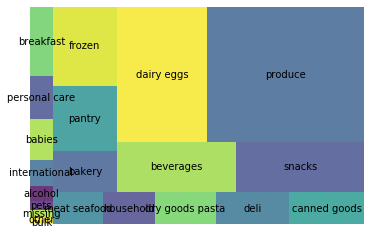

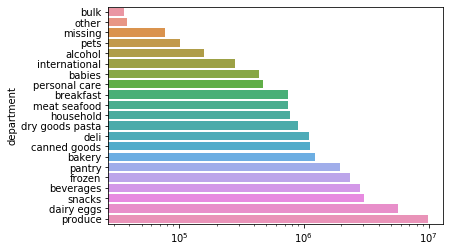

In [11]:
# Number of Orders per Department
p_c = data.groupby('department')['product_name'].count().sort_values()

print(p_c.nlargest(10))

# plot as Treemap
import squarify
squarify.plot(sizes=p_c.values, label=p_c.index, alpha=.8 )
plt.axis('off')
plt.savefig('departments_treemap.png')
plt.show() 

# maybe better as a barplot
plt.figure()
sns.barplot(x=p_c.values, y=p_c.index)
#plt.barh(y_pos,p_c.values)
#plt.yticks(y_pos, p_c.index)
#y_pos = np.arange(len(p_c.values))
plt.xscale('log')
plt.savefig('departments_bar.png', bbox_inches='tight')
plt.show()


In [44]:
# Number of Products per Department
n_p = data.groupby('department')['product_name'].value_counts()
print(n_p.head(10))

# Number of purchases per Category / Subcategory
p_c_s = data.groupby('department')['aisle'].value_counts()
print(p_c_s.head(10))

department  product_name      
alcohol     Sauvignon Blanc       8541
            Cabernet Sauvignon    6352
            Chardonnay            6346
            Beer                  6068
            Vodka                 5666
            India Pale Ale        4402
            Pinot Noir            4116
            Pinot Grigio          3351
            Malbec                2542
            Chardonnay Wine       2075
Name: product_name, dtype: int64


In [ ]:
# looking at a specific user / product transaction
data[(data.user_id == 1) & (data.product_id == 196)]

# Recommender Building
Der Code ist in die folgenden Module aufgeteilt<p>
1. Datenaufbereitung / Preprocessing<p>
2. Matrixerstellung<p>
3. Recommendations - hierbei ist ein Memory-Based und ein Modell-Based Ansatz implementiert<p>
4. Evaluation<p>


## 1. Datenaufbereitung
In diesem Modul werden die Rohdaten vorbereitet bzw. gefiltert. Dies ist kein direkter Task im Kontext eines Recommender Frameworks, es ist jedoch wichtig, diesen Schritt auch zu berücksichtigen. 
Als Input in diesem Modul erfolgt 
-	Der Datensatz, in diesem Fall sind dies Records / Transactions auf einer E-Commerce Site. (umgesetzt)
-	Ein Threshold, dass nur Produkte (Items) berücksichtigt werden welche n mal gekauft wurden (umgesetzt)
-	Ein Threshold, dass nur Kunden (Users) berücksichtigt werden, welche n Produkte gekauft haben (umgesetzt)
-	Ein Threshold, dass nur Kunden berücksichtigt werden, welche mehr als einmal eingekauft haben (nicht umgesetzt)
-	Die Definition, wie die Daten in ein Training und ein Test-Set unterteilt werden. (umgesetzt)

Als Resultat liefert das Modul einen reduzierter Datensatz, welcher die nicht relevanten Records entfernt hat und die Daten in Training und Test-Daten geteilt hat. 



### Reduktion der Transaktionen auf Basis der Produkte

In der Aufgabenstellung (#Referenz einfügen) ist gefordert, dass der Produktekatalog um 80% redzuiert werden soll. In einem ersten Schritt, wird aufgelistet, welche Produkte wie oft gekauft wurden. Diese Liste wird sortiert nach der Häufigkeit der Verkaufszahlen. Anschliessend werden die Transaktionen gefiltert um nur noch Einträge zu berücksichtigen, welche den Top 20 Prozent der Produkte entsprechen.

Total sind im Datensatz 49685 Produkte vorhanden. Wird diese Anzahl auf 20% reduziert, bleiben noch 9937 Produkte. Gesamthaft befinden sich im Datensatz 33'819'106 Transaktionen; gefiltert auf die Top 20% der Produkte bleiben immer noch 30'749'657 Transaktionen vorhanden.

Dies führt weiter dazu, dass auch das Produkt, welches am wenigesten oft gekauft wurde, immer noch 393-mal verkauft wurde.


In [2]:
# number of products
n_of_products = data.product_name.nunique()

# 20% of the products are
top_20 = int(n_of_products * 0.2)

# select the top products
n_of_products_bought = data.product_name.value_counts()
prod_f = n_of_products_bought.nlargest(top_20)
top_products = prod_f.index

# filter the transactions only for the top products
data_f = data[(data.product_name.isin(top_products))]

# product most and least bought
print('Product most bought: {0}'.format(prod_f.nlargest(1)))
print('Product least bought (top 20%): {0}'.format(prod_f.nsmallest(1)))


Product most bought: Banana    491291
Name: product_name, dtype: int64
Product least bought (top 20%): The Complete Cookie Double Chocolate    393
Name: product_name, dtype: int64


### Reduktion der Transaktionen auf Basis der User

Der Datensatz wird weiter reduziert, um nur User zu erhalten welche eine relevante Anzahl an Produkte gekauft haben. Im ersten Schritt wird aufgezeigt welche User wieviele Produkte gekauft haben. Anhand dieser Zahlen wird anschliessend eine Selektion der Top n User gemacht und die nicht benötigten aus den Transaktionen entfernt.

Annahme: Relevante User haben mindestens 30 verschiedene Produkte gekauft. (Muss vermutlich zu einem späteren Zeitpunkt noch angepasst werden)

Durch die Filterung der Transaktionen anhand der relevaten User wird der Datensatz ein weiters mal verkleiniert, es bleiben noch 28'501'910 Transaktionen

In [3]:
# Number of purchases per User and Product
n_of_purch_per_user = data_f.groupby(['user_id','product_id']).size()
# Number of Product per User
n_of_prod_per_user = n_of_purch_per_user.groupby('user_id').size()

# Users with most and least products
print('Users with most products: {0}'.format(n_of_prod_per_user.nlargest(20)))
print('Users with least products: {0}'.format(n_of_prod_per_user.nsmallest(20)))

# Filter for Users with more than n products
n = 30
prod_per_user_f = n_of_prod_per_user[(n_of_prod_per_user >= n)]
top_users = prod_per_user_f.index

# Select Transactions from Users with morn than n products bought
data_f = data_f[(data_f.user_id.isin(top_users))]

Users with most products: user_id
182401    647
152144    523
151378    493
60694     476
15124     471
106161    470
5557      466
185080    459
15229     458
71839     450
58965     444
129784    442
151994    442
148812    439
75304     434
16274     430
176478    430
178241    429
108564    427
143961    426
dtype: int64
Users with least products: user_id
113     1
218     1
318     1
619     1
1098    1
2296    1
2636    1
3182    1
3476    1
3987    1
4016    1
4088    1
4160    1
4259    1
4310    1
4433    1
5528    1
6283    1
6609    1
7109    1
dtype: int64


### Unterteilung der Daten in Test- und Train-Set

1. Ansatz: Zufällig 10% aller User1. Ansatz: Die Transaktionen von 10% der User gehen ins Testset, der Rest ist Trainingset


In [4]:
import random
# Umsetzung 1. Ansatz

# Create list of all User_IDs
user_ids = data_f.user_id.unique()
# Select random 10% of the Users
random_users = random.choices(user_ids, k=round(len(user_ids)*0.1))

#Train Set
data_train = data_f[~(data_f.user_id.isin(random_users))]

# Test Set
data_test = data_f[(data_f.user_id.isin(random_users))]

print('Train Set is saved as data_train, Test Set is saved as data_test')

Train Set is saved as data_train, Test Set is saved as data_test


## 2. Matrixerstellung

In diesem Modul wird aus dem reduzierten Datensatz eine User-Item Matrix generiert. Hierbei besteht die Möglichkeit die Ratings nach unterschiedlichen Berechnungsmethoden zu definieren. In einem ersten Ansatz wird mit einem unary / binary Rating gearbeitet. Das Rating sagt also lediglich aus, ob ein User ein Item gekauft hat (1) oder nicht (0). Nach Möglichkeiten können zu einem späteren Zeitpunkt noch weitere Berechnungsmethoden eingebaut werden.

In [7]:
del data_f

In [8]:
# Matrixerstellung

func = lambda x: 1

# Matrix for Testset
pivot_data = data_test[['user_id','product_id']]
matrix_test = pivot_data.pivot_table(index='user_id',columns='product_id',values='product_id',aggfunc=func,fill_value=0)
matrix_test.reset_index(inplace=True)

# Matrix for Trainset
pivot_data = data_train[['user_id','product_id']]
matrix_train = pivot_data.pivot_table(index='user_id',columns='product_id',values='product_id',aggfunc=func,fill_value=0)
matrix_train.reset_index(inplace=True)

matrix_test.head(10)

product_id,user_id,1,10,23,25,28,32,34,37,44,...,49630,49633,49640,49644,49652,49655,49667,49678,49680,49683
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,155,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,226,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,243,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3. Recommender
In diesem Modul werden die eigentlichen Recommendations berechnet. Wir planen hier zwei Modelle zu implementieren:
-	Memory-Based: User-based collaborative filtering. Hierbei wird in der User-Item Matrix nach Ähnlichen Usern gesucht und Items vorgeschlagen, welche bei diesen Usern am beliebtesten sind. Da wir mit einem binary Rating arbeiten, muss bei der Berechnung der Predictions ein pseudo-rating berechnet werden, anhand der Ähnlichkeit zweier User zueinander. Weiter muss dem Modul mittels Parameter ein Wert mitgegeben werden, der die k-nearest Neighbours definiert, also welche User noch als ähnlich betrachtet werden.
-	Modell-Based: Item-Item oder User-User collaborative filtering. Die User-Item Matrix wird mittels Matrix-Faktorisierung (Single Value Decomposition) in eine User-Factor und eine Factor-Item Matrix dekomposiert. Die Funktionsweisen und Details dazu müssen jedoch noch geklärt werden.


### Memory-Based Recommender

In [ ]:
# Code

### Modell-Based Recommender

In [ ]:
# Code

## 4. Evaluation
Bei der Evaluation wird das Test-Set in zwei Teile aufgeteilt (der Split geschieht im Datenverarbeitungsmodul), das Test- und das Trainingset. Hierbei befinden sich 90% der User im Trainingset. Für die Daten im Testset ist zudem zu beachten, dass es sich um User handelt welche tendenziell eine grosse Anzahl an Ratings aufweisen.  Dabei wird der Recommender mit dem Training-Set angelernt und mit dem Test-Set auf seine Leistung getestet. Bei den Usern im Testset werden einzelne Ratings entfernt (maskiert), welche dann mittels des Recommenders möglichst wieder errechnet werden. Als Beispiel:
Bei User A werden von total 40 bewerteten Items, bei 10 Items die Ratings entfernt. Anschliessend werden die Top 10 Recommendations für User A berechnet. Je grösser die Übereinstimmung der berechneten Recommendations, mit den zuvor gelöschten Items von User A ist, desto besser funktioniert der Recommender für User A. Dieser Schritt wird für sämtliche User aus dem Testset wiederholt. Der Durchschnitt aller berechneten Recommendations gegenüber ihren tatsächlichen Ratings, ergibt die Genauigkeit der Vorhersage für den verwendeten Recommender. 


In [ ]:
# Code

# Alles was hier noch kommt ist alt und wird in der finalen Version gelöscht. Ich lasse das aber mal noch stehen, da allenfalls mal was als noch verwendet werden kann.

In [12]:
# for testing and resource purposes, the set of transactions is reduced
data_f = data_f.head(10000)

# create a matrix with user, product and occurence as value (= number of times purchased)
''' depricated
matrix = pd.crosstab(data.user_id, data.product_id) 
# if we want precentage add parameter normalize=True

# this could alternatively be done by groupby
matrix_g = data.groupby(['user_id', 'product_id'])['product_id'].count().unstack().fillna(0)
'''
# with pivot_table - already normalized the ratings
# this needs to be improved, maybe with sigmoid function?
func = lambda x: x.count() / (1+x.count())
pivot_data = data_f[['user_id','product_id']]
matrix_p = pivot_data.pivot_table(index='user_id',columns='product_id',values='product_id',aggfunc=func,fill_value=0)

matrix_p.reset_index(inplace=True)

matrix_p.head(1)
# the matrix has a lot of empty values (is very sparse)

product_id,user_id,23,34,45,79,93,95,100,116,117,...,49519,49520,49533,49585,49588,49615,49628,49655,49680,49683
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
''' depricated
# converting the matrix back to a table for further processing
v_table = matrix.stack().reset_index()
v_table.columns = ['user_id','product_id','amount']

# remove rows with amount = 0
v_table = v_table[(v_table.amount != 0)]

print(v_table.head())

x = data.groupby(['user_id','product_id']).size()

print(x.head(20))

# Amount of times a product has been bought needs to be turned into a rating with range 0-1
# Not sure if sigmoid function or percentage is better, lets try both
v_table['rating_sig'] = v_table.amount / (1+v_table.amount)
v_table['rating_per'] = v_table.amount / v_table.amount.sum()
v_table.head()

# Renaming the column 'amount' to rating, since in the context of a recommender it's handeled as a rating
#v_table = v_table.rename(columns={'amount': 'rating'})

#Creating a dataframe with the number of ratings and the average rating for each product

# Getting the average rating of all products (Maybe this 'amount' value has to be converted to a fixed scale before?)
ratings = pd.DataFrame(v_table.groupby('product_id')['rating_sig'].mean())

# Add the number of times a Product has been bought/rated to the df
ratings['number_of_ratings'] = v_table.groupby('product_id')['amount'].count()

ratings.head()

# Lets look at the distribution of the ratings

import matplotlib.pyplot as plt
%matplotlib inline
ratings['number_of_ratings'].hist(bins=50)

ratings.sort_values('number_of_ratings', ascending=False).head(10)
'''

In [6]:
# geting a random product

random_product = data_f.sample(1)

print(random_product.product_name)

4232    Total 2% with Strawberry Lowfat Greek Strained...
Name: product_name, dtype: object


In [7]:
# this is a simple version of a collaborative filtering - memory based - recommender. It looks at similarities between a product and every other product in the catalog (matrix)
# this model requires no information about the product (or user). The more transactions there are the "better" the recommender becomes.
# a content-based approach is most likely not possible since there isn't much information about the product itself and no information about the user whatsoever

# Calculating the correlation between a product and the catalog

def recommend (product):
    r = matrix_p.corrwith(matrix_p[product])
    res = r.sort_values(ascending=False)[1:6] #the first product is always itself and therefore needs to be filtered
    print(res) 
    
    # print the results
    prod = data_f[(data.product_id == product)].product_name.unique()
    prod_r = data_f[(data.product_id.isin(res.index.tolist()))].product_name.unique()
    print('For {0}, the recommended products are {1}f'.format(prod,prod_r))

recommend(random_product.product_id.values[0])

# with an user-user recommender: maybe filter out the products the user has already bought?


product_id
22124    0.825800
40571    0.802313
24954    0.765544
1559     0.764117
4957     0.758430
dtype: float64
For ['Total 2% with Strawberry Lowfat Greek Strained Yogurt'], the recommended products are ['Total 0% Raspberry Yogurt' 'Cherry Pomegranate Greek Yogurt'
 'Total 0% with Honey Nonfat Greek Strained Yogurt'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz']f


In [15]:
# a memory based recommender doesnt perform well if the information is sparse - https://youtu.be/v_mONWiFv0k
# calculate the sparcity: # of ratings / total # elements
# in theory the recommender should work better with items which have been bought by many different users. Since the matrix is built with transaction data, each product is at least bought by one person

matrix_p.isnull().sum()

product_id
user_id    0
23         0
34         0
45         0
79         0
          ..
49615      0
49628      0
49655      0
49680      0
49683      0
Length: 2580, dtype: int64